В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score
#import torch.nn as nn

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [18]:
class NeuralNet:
   
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000, hidden_layer_sizes =(4,4), tol=1e-6, notimp_iters=200 ):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes =hidden_layer_sizes;
        #self.relu = nn.ReLU();
        self.tol =tol;
        self.num_layers =len(hidden_layer_sizes);
        self.notimp_iters = notimp_iters;
       # self.parameters=None
        
         
    def __softmax(self, Z):
        return np.exp(Z)/np.sum(np.exp(Z))
        
    
    def __normalize(self, X, mean = None, std = None):
    
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_arr):
        W_arr =[];
        b_arr =[];
       
        ######
        W1 = np.random.randn(n_arr[0], n_x)*0.01;
        b1 = np.zeros((n_arr[0], 1));
        W_arr.append(W1);
        b_arr.append(b1);
        
     
        for n_l in range(1,len(n_arr)):
            W_temp =np.random.randn(n_arr[n_l], n_arr[n_l-1]) * 0.01;
            b_temp = np.zeros((n_arr[n_l], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        
        
        W2 =np.random.randn(1, n_arr[len(n_arr)-1]) * 0.01
        b2 = 0;
        
        W_arr.append(W2);
        b_arr.append(b2);
        
        
        self.parameters = {"W_arr" : W_arr, "b_arr" : b_arr}
       
    def __forward_propagation(self, X):
        
        W_arr =self.parameters["W_arr"]
        b_arr = self.parameters["b_arr"]
        
        W1 = W_arr[0];
        b1 = b_arr[0];
        
        W2 =W_arr[len(W_arr)-1];
        b2 =b_arr[len(b_arr)-1];
        
        Z_arr =[];
        A_arr =[];
        
        Z1 =np.dot(W1,X)+b1;
        A1 = self.__sigmoid(Z1);
        
        
        Z_arr.append(Z1);
        A_arr.append(A1);
        
       
     
        for l in range(1,self.num_layers):
            Z_temp = np.dot(W_arr[l],A_arr[l-1])+b_arr[l];
            A_temp = self.__sigmoid(Z_temp);
            Z_arr.append(Z_temp);
            A_arr.append(A_temp);

            
     #added
        Z_temp = np.dot(W_arr[self.num_layers],A_arr[self.num_layers-1])+b_arr[self.num_layers];
        A_temp = self.__softmax(Z_temp);
        Z_arr.append(Z_temp);
        A_arr.append(A_temp);
            
        cache =(W_arr,b_arr,Z_arr,A_arr);
        
        return A_arr[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
 
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W_arr,b_arr,Z_arr,A_arr) = cache

        
        dZ_arr=[];
        dW_arr =[];
        dA_arr=[];
        db_arr =[];
        
        dZ2 = A_arr[-1] -Y;
        dW2 = 1. / m * np.dot(dZ2, A_arr[-2].T);
        db2 =1. / m * np.sum(dZ2, axis = 1, keepdims = True);
        dA2 =np.dot(W_arr[-1].T,dZ2);
        dZ_arr.insert(0,dZ2); 
        dW_arr.insert(0,dW2);
        db_arr.insert(0,db2);
        dA_arr.insert(0,dA2);
             
   
        for l_inv in range(len(W_arr)-2,0,-1):

            dZ_temp =np.multiply(dA_arr[0], np.multiply(A_arr[l_inv], 1 - A_arr[l_inv]));
            dW_temp =1. / m * np.dot(dZ_temp, A_arr[l_inv-1].T);
            db_temp =1. / m * np.sum(dZ_temp, axis = 1, keepdims = True);
            dA_temp =np.dot(W_arr[l_inv].T,dZ_temp);
            
            dZ_arr.insert(0,dZ_temp);
            dW_arr.insert(0,dW_temp);
            dA_arr.insert(0,dA_temp);
            db_arr.insert(0,db_temp);
        
       
        dA1 =dA_arr[0];
        dZ1 = np.multiply(dA1, np.multiply(A_arr[0], 1 - A_arr[0]));
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 =1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        
        dZ_arr.insert(0,dZ1); 
        dW_arr.insert(0,dW1);
        db_arr.insert(0,db1);
       
        grads ={"dZ_arr":dZ_arr,"dW_arr":dW_arr,"db_arr":db_arr}
        return grads
  
    
   
        
    def __update_parameters(self, grads):
            
        W_arr =self.parameters["W_arr"];
        b_arr =self.parameters["b_arr"];
        dW_arr =grads["dW_arr"];
        db_arr =grads["db_arr"];
        
        Wnew =W_arr.copy();
        bnew = b_arr.copy();
        for l in range(0,len(W_arr)):
            Wnew[l]-=self.learning_rate * dW_arr[l];
            bnew[l]-=self.learning_rate * db_arr[l];
        self.parameters["W_arr"] = Wnew;
        self.parameters["b_arr"] = bnew;
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        improve_costs =[]
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x,self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
                
            if i%self.notimp_iters ==0:
                improve_costs.append(cost);
                if len(improve_costs) >2:
                    if abs(improve_costs[len(improve_costs)-1] - improve_costs[len(improve_costs)-2]) < self.tol:
                        return;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [19]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


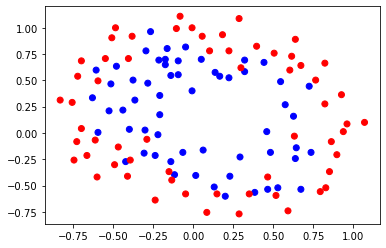

In [20]:
plot_data(X, Y)

In [27]:
cls = NeuralNet(normalize = True, learning_rate = 0.001, num_iter = 10001,hidden_layer_sizes = (7,2),notimp_iters=100000,tol=1e-8)


0-th iteration: 2.3492402649057063
1000-th iteration: 2.3492400339736386
2000-th iteration: 2.349238564639207
3000-th iteration: 2.3492337532315846
4000-th iteration: 2.3492200617194197
5000-th iteration: 2.349186327155258
6000-th iteration: 2.3491232990921196
7000-th iteration: 2.349037087375395
8000-th iteration: 2.348945633224156
9000-th iteration: 2.3488639011495613
10000-th iteration: 2.3487982780699204


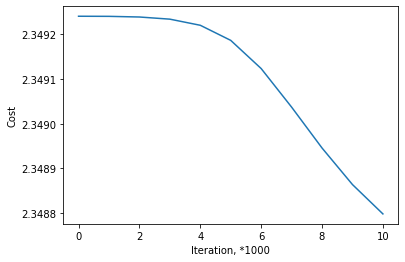

In [28]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [29]:
print(cls.parameters)

{'W_arr': [array([[-0.00269458, -0.00483325],
       [-0.01650056, -0.01080413],
       [-0.02483449,  0.00528066],
       [-0.01893881,  0.00607865],
       [-0.01315126,  0.00042052],
       [-0.0243258 ,  0.0156846 ],
       [-0.02464843,  0.00265965]]), array([[0.47212118, 0.48718155, 0.47637747, 0.4899029 , 0.50965347,
        0.48090096, 0.50473009],
       [0.49808863, 0.48127337, 0.4979547 , 0.48894991, 0.48878475,
        0.50275409, 0.48499577]]), array([[3.45205601, 3.50476921]])], 'b_arr': [array([[0.11432047],
       [0.11372908],
       [0.11505922],
       [0.11612016],
       [0.12067927],
       [0.11719882],
       [0.11854637]]), array([[0.95678593],
       [0.9746663 ]]), array([[4.83099153]])]}


In [30]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.00851613, 0.99148387],
       [0.00848743, 0.99151257],
       [0.00854055, 0.99145945],
       [0.00856868, 0.99143132],
       [0.00859535, 0.99140465],
       [0.00859222, 0.99140778],
       [0.00856331, 0.99143669],
       [0.00854005, 0.99145995],
       [0.00847046, 0.99152954],
       [0.00844465, 0.99155535],
       [0.00839167, 0.99160833],
       [0.00836298, 0.99163702],
       [0.00834653, 0.99165347],
       [0.00832753, 0.99167247],
       [0.00838176, 0.99161824],
       [0.0084299 , 0.9915701 ],
       [0.00846061, 0.99153939],
       [0.00850969, 0.99149031],
       [0.00853263, 0.99146737],
       [0.00859206, 0.99140794],
       [0.00861632, 0.99138368],
       [0.00861534, 0.99138466],
       [0.00860156, 0.99139844],
       [0.00856133, 0.99143867],
       [0.00849742, 0.99150258],
       [0.00842863, 0.99157137],
       [0.00837572, 0.99162428],
       [0.00833285, 0.99166715],
       [0.00852241, 0.99147759],
       [0.00855852, 0.99144148],
       [0.

In [31]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
accuracy_score(Y, Y_hat)

0.5084745762711864

<ipython-input-4-1d8d12161a03>:10: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')


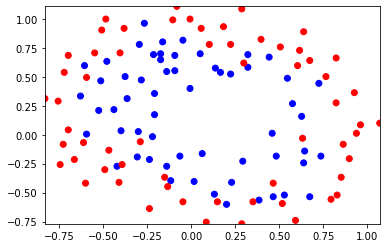

In [34]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [35]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (5,10,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [36]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate_init=0.01,
              max_iter=10000, solver='sgd')

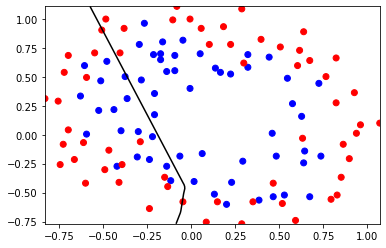

In [37]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [38]:
accuracy_score(Y, clf.predict(X))

0.4745762711864407

In [39]:
clf.n_iter_

74

# Second task

In [40]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))


Training set: X=(100, 2), y=(100,)


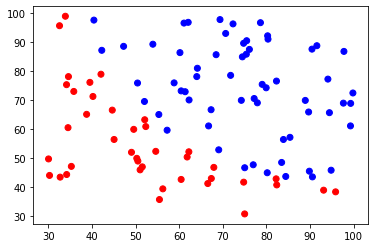

In [41]:
plot_data(X, Y)

In [44]:
cls = NeuralNet(normalize = True, learning_rate = 0.001, num_iter = 10001,hidden_layer_sizes = (7,2),notimp_iters=100000,tol=1e-8)

0-th iteration: 2.7671222473815233
1000-th iteration: 2.7671221830538015
2000-th iteration: 2.7671218154592157
3000-th iteration: 2.7671206412782277
4000-th iteration: 2.7671176955672756
5000-th iteration: 2.767112159626114
6000-th iteration: 2.7671048488173504
7000-th iteration: 2.76709760952264
8000-th iteration: 2.7670916274127593
9000-th iteration: 2.7670871695421675
10000-th iteration: 2.767084053989294


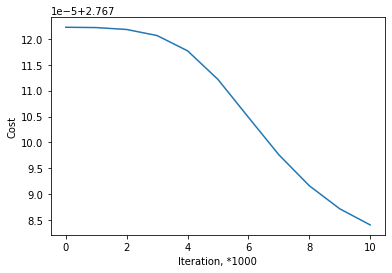

In [45]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [46]:

print(cls.parameters)

{'W_arr': [array([[-0.00645964, -0.00302183],
       [ 0.01576564,  0.00572703],
       [ 0.01273245, -0.00370175],
       [-0.01166324,  0.02599112],
       [ 0.01015068,  0.00866696],
       [ 0.00431075,  0.00085879],
       [ 0.00290117,  0.00158482]]), array([[0.59178914, 0.58068906, 0.59324062, 0.58034566, 0.59664351,
        0.60268686, 0.58604493],
       [0.58178222, 0.5915909 , 0.58579263, 0.59045182, 0.59238047,
        0.59533224, 0.59130293]]), array([[4.52458172, 4.51411159]])], 'b_arr': [array([[0.16497626],
       [0.16456092],
       [0.16640447],
       [0.16418017],
       [0.16906727],
       [0.17150924],
       [0.16595741]]), array([[1.14038039],
       [1.13729527]]), array([[5.90059]])]}


In [47]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.00999955, 0.99000045],
       [0.00999789, 0.99000211],
       [0.00999936, 0.99000064],
       [0.01000072, 0.98999928],
       [0.01000083, 0.98999917],
       [0.00999891, 0.99000109],
       [0.01000121, 0.98999879],
       [0.00999942, 0.99000058],
       [0.01000127, 0.98999873],
       [0.00999958, 0.99000042],
       [0.0099997 , 0.9900003 ],
       [0.00999871, 0.99000129],
       [0.01000098, 0.98999902],
       [0.01000152, 0.98999848],
       [0.00999962, 0.99000038],
       [0.01000066, 0.98999934],
       [0.00999951, 0.99000049],
       [0.0099992 , 0.9900008 ],
       [0.01000135, 0.98999865],
       [0.00999953, 0.99000047],
       [0.00999901, 0.99000099],
       [0.01000074, 0.98999926],
       [0.00999875, 0.99000125],
       [0.00999803, 0.99000197],
       [0.01000051, 0.98999949],
       [0.01000006, 0.98999994],
       [0.00999951, 0.99000049],
       [0.00999964, 0.99000036],
       [0.00999917, 0.99000083],
       [0.0099991 , 0.9900009 ],
       [0.

In [48]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [49]:
accuracy_score(Y, Y_hat)

0.4

<ipython-input-4-1d8d12161a03>:10: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')


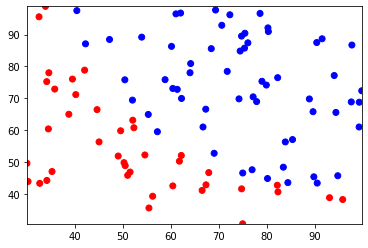

In [50]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [51]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (800,), max_iter = 10000, activation = 'tanh', solver = 'sgd', learning_rate_init = 0.0005, learning_rate = 'constant')


In [52]:
clf.fit(X, Y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(800,),
              learning_rate_init=0.0005, max_iter=10000, solver='sgd')

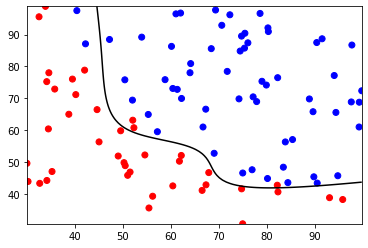

In [53]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [54]:
accuracy_score(Y, clf.predict(X))

0.95